In [109]:
import os
from cv2 import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import random 
from tqdm import tqdm

In [ ]:
%matplotlib inline

In [75]:
root_path = None # fill in with path to bg_challenge_train_val

root_only_fg_path = os.path.join(root_path, 'only_fg')
root_only_bg_t_path = os.path.join(root_path, 'only_bg_t')

In [73]:
def get_images_paths(path, ext='.JPEG'):
    return [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == ext]

In [77]:
foregrounds = get_images_paths(root_only_fg_path)
backgrounds = get_images_paths(root_only_bg_t_path)

In [129]:
def calculate_mask(img_path, show=False):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    #convert img to grey
    img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #set a thresh
    thresh = 3
    #get threshold image
    ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
    #find contours
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #create an empty image for contours
    print(img.shape)
    img_contours = np.zeros(img.shape[:2])
    # draw the contours on the empty image
    cv2.drawContours(img_contours, contours, -1, 1 , thickness=cv2.FILLED)
    # erode small spots
    img_contours = cv2.erode(img_contours,np.ones((3,3),np.uint8),iterations = 1)
    # close gaps with bigger kernel
    img_contours = cv2.dilate(img_contours,np.ones((7,7),np.uint8),iterations = 1)
    if show:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        ax1.imshow(img_contours)
        ax2.imshow(img)
        img_overlayed = deepcopy(img)
        idx = (img_overlayed)
        ax3.imshow(img)
    img_contours = img_contours.astype('int8')
    return img_contours


In [107]:
random.seed(42)
r_frgs = random.sample(foregrounds, 10)

(320, 480, 3)
(313, 500, 3)
(690, 502, 3)
(500, 368, 3)
(500, 333, 3)
(400, 500, 3)
(404, 537, 3)
(338, 500, 3)
(375, 500, 3)
(400, 500, 3)


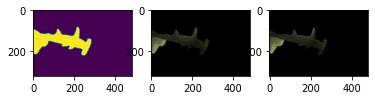

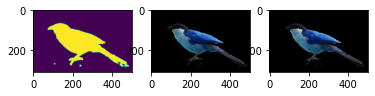

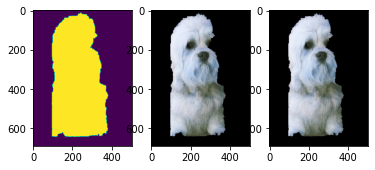

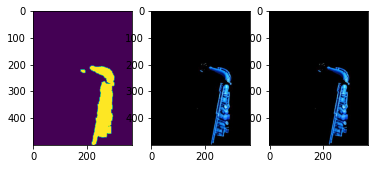

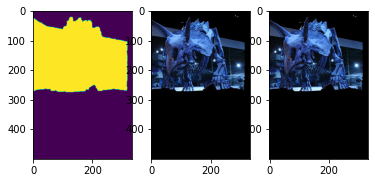

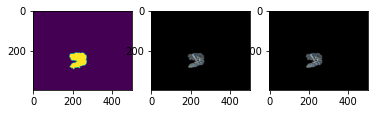

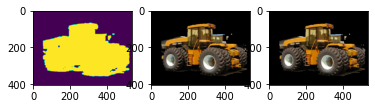

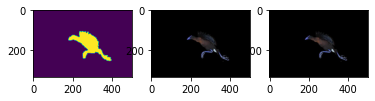

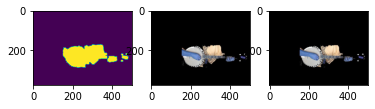

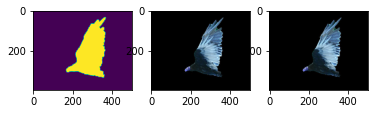

In [130]:
for im in r_frgs:
    calculate_mask(im, show=True);

### Check processing time

Check if it is better to pre-compute masks and load them from disks or compute them on-the-fly

In [88]:
random.seed(17)
rand_fg_path = random.choice(foregrounds)
rand_fg_mask = calculate_mask(rand_fg_path, show=False)
np.save('test.npy', rand_fg_mask)

In [94]:
%%timeit
_ = np.load('test.npy')

324 µs ± 6.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [96]:
img = cv2.imread(rand_fg_path, cv2.IMREAD_UNCHANGED)

In [97]:
%%timeit

#convert img to grey
img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#set a thresh
thresh = 3
#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#create an empty image for contours
img_contours = np.zeros(img.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, (1, 1, 1), thickness=cv2.FILLED)
# erode small spots
img_contours = cv2.erode(img_contours,np.ones((3,3),np.uint8),iterations = 1)
# close gaps with bigger kernel
img_contours = cv2.dilate(img_contours,np.ones((7,7),np.uint8),iterations = 1)


14.3 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
def calculate_mask_dataset(root_path):
    only_fg_path = os.path.join(root_path, 'only_fg')
    masks_path = os.path.join(root_path, 'masks')
    os.makedirs(masks_path, exist_ok=True)
    image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(only_fg_path) for f in filenames if os.path.splitext(f)[1] == '.JPEG']
    for im_path in tqdm(image_paths):
        im_path_relative = os.path.relpath(im_path, only_fg_path)
        im_mask_path = os.path.join(masks_path, im_path_relative)
        if os.path.exists(im_mask_path + '.npy'):
            continue
        os.makedirs(os.path.dirname(im_mask_path), exist_ok=True)
        mask = calculate_mask(im_path, show=False)

        np.save(im_mask_path, mask)

In [124]:
# fast to read, costly to store (~20GB uncompressed)
# calculate_mask_dataset(root_path)


100%|████████████████████████████████████████████████████████████████████████████| 49590/49590 [09:39<00:00, 85.58it/s]
